In [ ]:
# Problem – Implementation

# In this exercise, the goal is to implement a Multilayer Perceptron (MLP) neural network using libraries such as NumPy, PyTorch, or TensorFlow (or similar).

# The dataset provided in the data folder contains labeled data with two classes. The goal is to perform a classification task using a neural network. The data should be split into 70% for training and 30% for testing.

# You must train the model separately for each of the following parameter combinations and evaluate its performance. In each case, only one parameter setting should be changed while the others remain fixed.

# For example, you can train the network once with the tanh activation function and once with the logistic activation function, and then compare the results.

# Parameters to vary:

# Activation function type in the hidden layer (for example: tanh and logistic).

# Different values of initial learning rate (for example: high vs. low).

# Different optimizers (for example: SGD vs. Adam).

# Different numbers of training epochs (for example: 50, 100).

# For each parameter combination, do the following:

# Plot the decision boundary of the model to show how the data is separated by the network.

# Draw the ROC curve for the model and compare it with other parameter combinations.

# Compare and analyze the performance of each parameter combination.

In [1]:
!pip -q install torch torchvision torchaudio scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd, numpy as np, torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools, textwrap, warnings
warnings.filterwarnings("ignore")

# === CHANGE THIS to your actual file location in Drive ===
CSV_PATH = "/content/drive/MyDrive/Dataset.csv"  # e.g., "/content/drive/MyDrive/your_folder/Dataset.csv"
assert os.path.exists(CSV_PATH), f"File not found at {CSV_PATH}"
print("Found:", CSV_PATH)

Mounted at /content/drive
Found: /content/drive/MyDrive/Dataset.csv


In [4]:
# --- Load dataset ---
df = pd.read_csv(CSV_PATH)

# (optional) peek
print("Columns:", list(df.columns))
print(df.head(3))

# Heuristic: find label/target column (override if needed)
candidates = ["label","target","y","class","Class","Outcome"]
label_col = next((c for c in candidates if c in df.columns), df.columns[-1])
print("Detected label column:", label_col)

# Split features/labels
y_raw = df[label_col].values
X_df = df.drop(columns=[label_col])

# Keep only numeric columns (warn if we drop any)
non_numeric = X_df.select_dtypes(exclude=["number"]).columns.tolist()
if non_numeric:
    print("Dropped non-numeric columns:", non_numeric)
X_df = X_df.select_dtypes(include=["number"])

# Handle missing values (simple strategy)
X_df = X_df.fillna(X_df.mean())

X = X_df.values.astype(np.float32)

# Encode labels to 0/1 if needed
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y_raw).astype(np.int64)
classes = list(le.classes_)
assert len(np.unique(y)) == 2, f"Expecting binary classes, got {np.unique(y)}"

# Train/test split 70/30 (stratified)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Standardize (fit on train, apply to test)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train).astype(np.float32)
X_test_std  = scaler.transform(X_test).astype(np.float32)

import torch
X_train_t = torch.from_numpy(X_train_std)
y_train_t = torch.from_numpy(y_train)
X_test_t  = torch.from_numpy(X_test_std)
y_test_t  = torch.from_numpy(y_test)

print("Shapes: train", X_train_t.shape, "test", X_test_t.shape)
print("Class mapping (encoded -> original):", {i:c for i,c in enumerate(classes)})

Columns: ['Feature  0', 'Feature  1', 'target']
   Feature  0  Feature  1  target
0    0.972838   -0.499515       1
1    1.848449    0.025040       1
2   -0.129004    1.014398       0
Detected label column: target
Shapes: train torch.Size([1050, 2]) test torch.Size([450, 2])
Class mapping (encoded -> original): {0: np.int64(0), 1: np.int64(1)}


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import numpy as np

# --- Simple MLP ---
class MLP(nn.Module):
    def __init__(self, in_dim, hidden=32, activation="tanh"):
        super().__init__()
        act = nn.Tanh() if activation=="tanh" else nn.Sigmoid()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            act,
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)  # logits

def train_model(Xtr, ytr, Xte, yte, *,
                activation="tanh", lr=1e-2, optimizer_name="SGD",
                epochs=50, batch_size=64, hidden=32, seed=0):
    torch.manual_seed(seed)
    model = MLP(Xtr.shape[1], hidden=hidden, activation=activation)

    if optimizer_name.upper() == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.upper() == "ADAM":
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("optimizer_name must be 'SGD' or 'Adam'")

    loss_fn = nn.BCEWithLogitsLoss()
    loader = DataLoader(TensorDataset(Xtr, ytr.float()), batch_size=batch_size, shuffle=True)

    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()

    # eval
    model.eval()
    with torch.no_grad():
        logits = model(Xte).cpu().numpy()
        probs  = 1/(1+np.exp(-logits))
        preds  = (probs >= 0.5).astype(int)

    fpr, tpr, _ = roc_curve(yte, probs)
    return {
        "accuracy": accuracy_score(yte, preds),
        "precision": precision_score(yte, preds, zero_division=0),
        "recall": recall_score(yte, preds, zero_division=0),
        "f1": f1_score(yte, preds, zero_division=0),
        "confusion_matrix": confusion_matrix(yte, preds),
        "auc": auc(fpr, tpr), "fpr": fpr, "tpr": tpr,
        "model": model
    }


In [7]:
import pandas as pd

# load your CSV into df
df = pd.read_csv("/content/drive/MyDrive/Dataset.csv")
print(df.head())

   Feature  0  Feature  1  target
0    0.972838   -0.499515       1
1    1.848449    0.025040       1
2   -0.129004    1.014398       0
3   -0.167436    1.043274       0
4   -0.390084    0.913158       0


In [8]:
# === ONE-TIME PREP (run this before PCA/plots) ===
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1) Features/labels from your loaded df
label_col = "target"           # change if your label has a different name
X = df.drop(columns=[label_col]).values.astype(np.float32)
y = df[label_col].values

# 2) Ensure labels are 0/1
le = LabelEncoder()
y = le.fit_transform(y).astype(np.int64)

# 3) Train/test split 70/30 + standardize
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train).astype(np.float32)
X_test_std  = scaler.transform(X_test).astype(np.float32)

# 4) Torch tensors used by train_model(...)
X_train_t = torch.from_numpy(X_train_std)
y_train_t = torch.from_numpy(y_train)
X_test_t  = torch.from_numpy(X_test_std)
y_test_t  = torch.from_numpy(y_test)

print("Prepared:", X_train_std.shape, X_test_std.shape)


Prepared: (1050, 2) (450, 2)


In [10]:
import numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

class MLP(nn.Module):
    def __init__(self, in_dim, hidden=32, activation="tanh"):
        super().__init__()
        act = nn.Tanh() if activation == "tanh" else nn.Sigmoid()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            act,
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)  # logits

def train_model(Xtr, ytr, Xte, yte, *,
                activation="tanh", lr=1e-2, optimizer_name="SGD",
                epochs=50, batch_size=64, hidden=32, seed=0):
    torch.manual_seed(seed)
    model = MLP(Xtr.shape[1], hidden=hidden, activation=activation)

    if optimizer_name.upper() == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.upper() == "ADAM":
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("optimizer_name must be 'SGD' or 'Adam'")

    loss_fn = nn.BCEWithLogitsLoss()
    loader = DataLoader(TensorDataset(Xtr, ytr.float()), batch_size=batch_size, shuffle=True)

    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

    model.eval()
    with torch.no_grad():
        logits = model(Xte).cpu().numpy()
        probs  = 1.0 / (1.0 + np.exp(-logits))
        preds  = (probs >= 0.5).astype(int)

    fpr, tpr, _ = roc_curve(yte, probs)

    return {
        "accuracy": accuracy_score(yte, preds),
        "precision": precision_score(yte, preds, zero_division=0),
        "recall": recall_score(yte, preds, zero_division=0),
        "f1": f1_score(yte, preds, zero_division=0),
        "confusion_matrix": confusion_matrix(yte, preds),
        "auc": auc(fpr, tpr),
        "fpr": fpr,
        "tpr": tpr,
        "model": model,
    }


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt, numpy as np, textwrap, torch

# PCA to 2D for visualization (your MLP still trains on full features elsewhere)
pca2 = PCA(n_components=2).fit(X_train_std)
Xtr_2d = pca2.transform(X_train_std).astype(np.float32)
Xte_2d = pca2.transform(X_test_std).astype(np.float32)
Xtr_2d_t = torch.from_numpy(Xtr_2d)
Xte_2d_t = torch.from_numpy(Xte_2d)

def plot_decision_boundary_on_pca2(cfg, hidden=16):
    viz = train_model(
        Xtr_2d_t, y_train_t, Xte_2d_t, y_test_t,
        activation=cfg["activation"], lr=cfg["lr"],
        optimizer_name=cfg["optimizer"], epochs=cfg["epochs"],
        hidden=hidden, seed=0
    )
    x_min, x_max = Xtr_2d[:,0].min()-1, Xtr_2d[:,0].max()+1
    y_min, y_max = Xtr_2d[:,1].min()-1, Xtr_2d[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,300), np.linspace(y_min,y_max,300))
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

    with torch.no_grad():
        logits = viz["model"](torch.from_numpy(grid)).numpy()
        Z = (1/(1+np.exp(-logits)) >= 0.5).astype(int).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.25, levels=[-1,0,1])
    plt.scatter(Xtr_2d[:,0], Xtr_2d[:,1], c=y_train, s=18, edgecolors='k', alpha=0.75, label="train")
    plt.scatter(Xte_2d[:,0], Xte_2d[:,1], c=y_test, marker='x', s=35, label="test")
    t = textwrap.fill(f"Decision boundary (PCA-2D) | act={cfg['activation']}, lr={cfg['lr']}, opt={cfg['optimizer']}, epochs={cfg['epochs']}", 60)
    plt.title(t); plt.xlabel("PCA1"); plt.ylabel("PCA2"); plt.legend(); plt.show()

def plot_rocs(results):
    plt.figure(figsize=(6,5))
    for name, m in results.items():
        plt.plot(m["fpr"], m["tpr"], label=f"{name} (AUC={m['auc']:.3f})")
    plt.plot([0,1],[0,1],'--', linewidth=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC curves"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()


In [12]:
baseline = {"activation":"tanh", "lr":1e-2, "optimizer":"SGD", "epochs":50}
experiments = {
    "baseline": baseline,
    "act=logistic": {**baseline, "activation":"logistic"},
    "lr=0.001":     {**baseline, "lr":1e-3},
    "lr=0.1":       {**baseline, "lr":1e-1},
    "opt=Adam":     {**baseline, "optimizer":"Adam"},
    "epochs=100":   {**baseline, "epochs":100},
}

results = {}
for name, cfg in experiments.items():
    print(f"Training: {name} -> {cfg}")
    results[name] = train_model(
        X_train_t, y_train_t, X_test_t, y_test_t,
        activation=cfg["activation"], lr=cfg["lr"],
        optimizer_name=cfg["optimizer"], epochs=cfg["epochs"],
        hidden=32, seed=0
    )
print("Done.")

Training: baseline -> {'activation': 'tanh', 'lr': 0.01, 'optimizer': 'SGD', 'epochs': 50}
Training: act=logistic -> {'activation': 'logistic', 'lr': 0.01, 'optimizer': 'SGD', 'epochs': 50}
Training: lr=0.001 -> {'activation': 'tanh', 'lr': 0.001, 'optimizer': 'SGD', 'epochs': 50}
Training: lr=0.1 -> {'activation': 'tanh', 'lr': 0.1, 'optimizer': 'SGD', 'epochs': 50}
Training: opt=Adam -> {'activation': 'tanh', 'lr': 0.01, 'optimizer': 'Adam', 'epochs': 50}
Training: epochs=100 -> {'activation': 'tanh', 'lr': 0.01, 'optimizer': 'SGD', 'epochs': 100}
Done.


In [13]:
import pandas as pd

rows = []
for name, m in results.items():
    tn, fp, fn, tp = m["confusion_matrix"].ravel()
    rows.append({
        "Experiment": name,
        "Accuracy": m["accuracy"],
        "Precision": m["precision"],
        "Recall": m["recall"],
        "F1": m["f1"],
        "AUC": m["auc"],
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    })
summary_df = pd.DataFrame(rows).sort_values("AUC", ascending=False).reset_index(drop=True)
summary_df

,Experiment,Accuracy,Precision,Recall,F1,AUC,TN,FP,FN,TP
0,opt=Adam,1.000000,1.000000,1.00,1.000000,1.000000,225,0,0,225
1,lr=0.1,0.935556,0.949541,0.92,0.934537,0.987714,214,11,18,207
2,act=logistic,0.902222,0.920930,0.88,0.900000,0.971931,208,17,27,198
3,epochs=100,0.900000,0.916667,0.88,0.897959,0.971773,207,18,27,198
4,baseline,0.902222,0.920930,0.88,0.900000,0.971457,208,17,27,198
5,lr=0.001,0.902222,0.920930,0.88,0.900000,0.970904,208,17,27,198


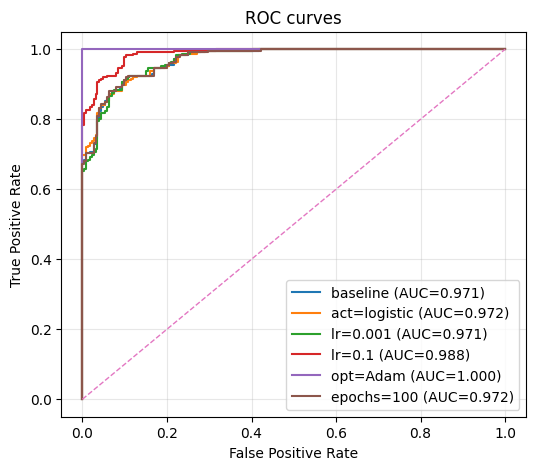

In [14]:
plot_rocs(results)

Plotting decision boundary for: baseline


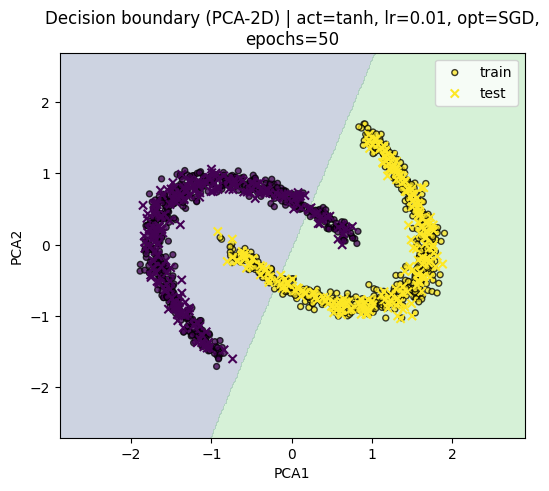

Plotting decision boundary for: act=logistic


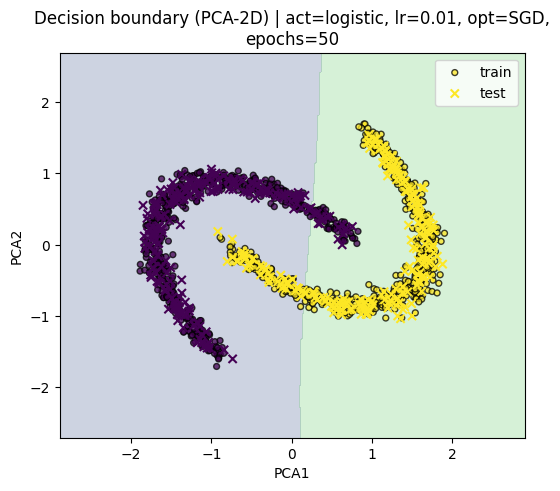

Plotting decision boundary for: lr=0.001


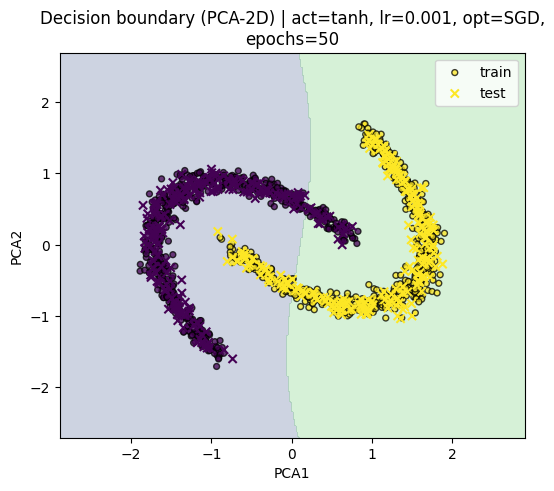

Plotting decision boundary for: lr=0.1


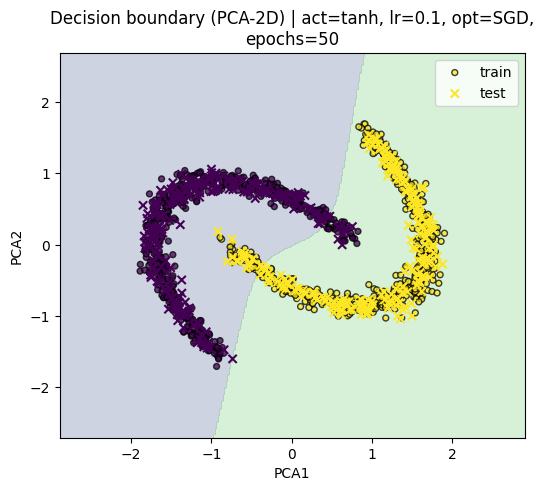

Plotting decision boundary for: opt=Adam


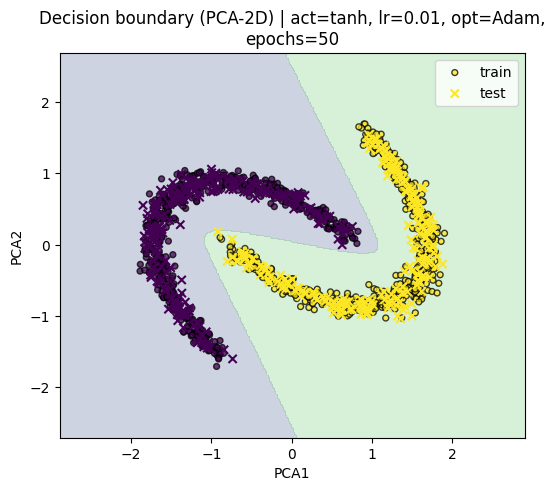

Plotting decision boundary for: epochs=100


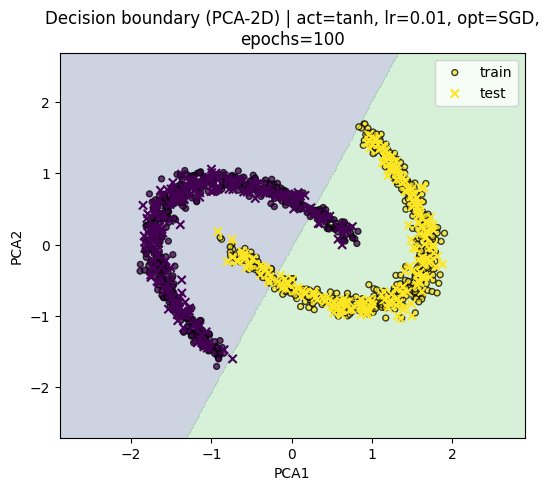

In [15]:
for name, cfg in experiments.items():
    print("Plotting decision boundary for:", name)
    plot_decision_boundary_on_pca2(cfg, hidden=16)

Plotting: baseline


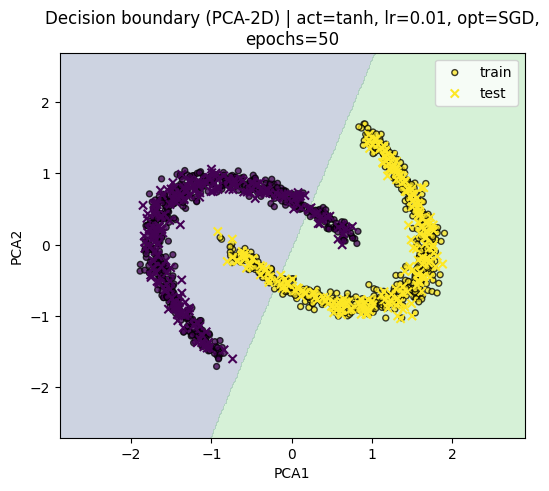

Plotting: opt=Adam


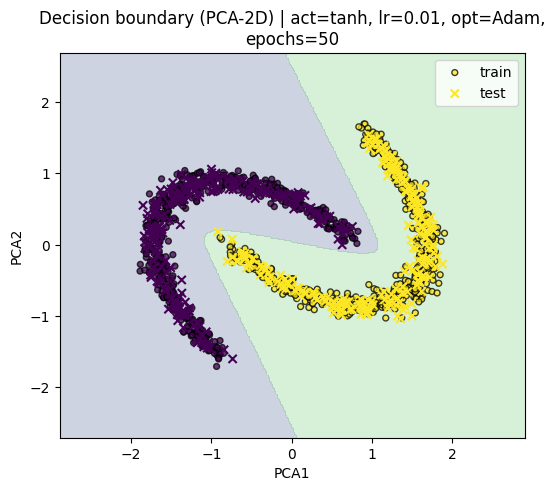

Plotting: lr=0.1


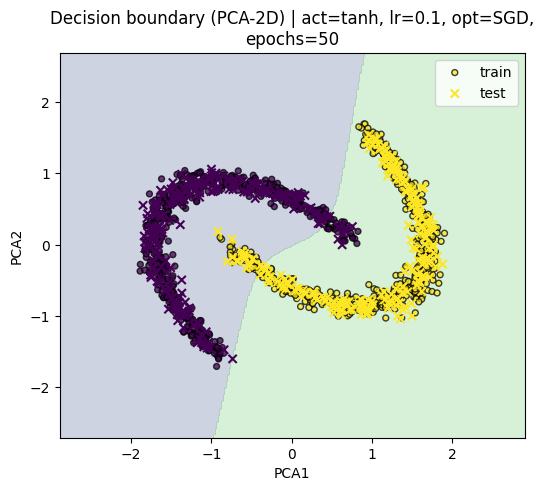

In [16]:
for key in ["baseline", "opt=Adam", "lr=0.1"]:
    print("Plotting:", key)
    plot_decision_boundary_on_pca2(experiments[key], hidden=16)

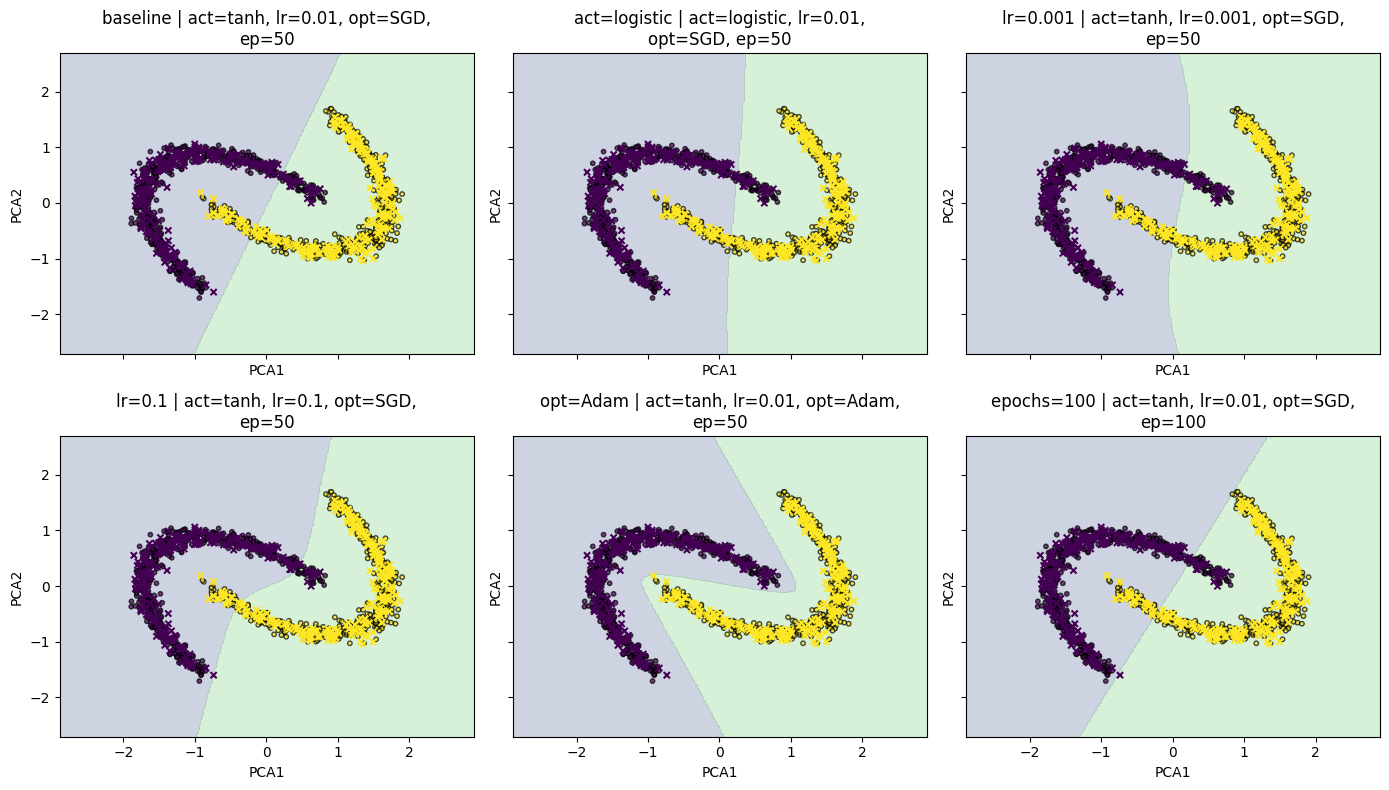

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch, textwrap

# precompute limits so all panels share the same view
x_min, x_max = Xtr_2d[:,0].min()-1, Xtr_2d[:,0].max()+1
y_min, y_max = Xtr_2d[:,1].min()-1, Xtr_2d[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min,x_max,300), np.linspace(y_min,y_max,300))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
grid_t = torch.from_numpy(grid)

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()
for ax, (name, cfg) in zip(axes, experiments.items()):
    viz = train_model(Xtr_2d_t, y_train_t, Xte_2d_t, y_test_t,
                      activation=cfg["activation"], lr=cfg["lr"],
                      optimizer_name=cfg["optimizer"], epochs=cfg["epochs"],
                      hidden=16, seed=0)
    with torch.no_grad():
        logits = viz["model"](grid_t).numpy()
        Z = (1/(1+np.exp(-logits)) >= 0.5).astype(int).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25, levels=[-1,0,1])
    ax.scatter(Xtr_2d[:,0], Xtr_2d[:,1], c=y_train, s=10, edgecolors='k', alpha=0.7)
    ax.scatter(Xte_2d[:,0], Xte_2d[:,1], c=y_test, marker='x', s=20)
    t = textwrap.fill(f"{name} | act={cfg['activation']}, lr={cfg['lr']}, opt={cfg['optimizer']}, ep={cfg['epochs']}", 40)
    ax.set_title(t)
for ax in axes: ax.set_xlabel("PCA1"); ax.set_ylabel("PCA2")
plt.tight_layout(); plt.show()


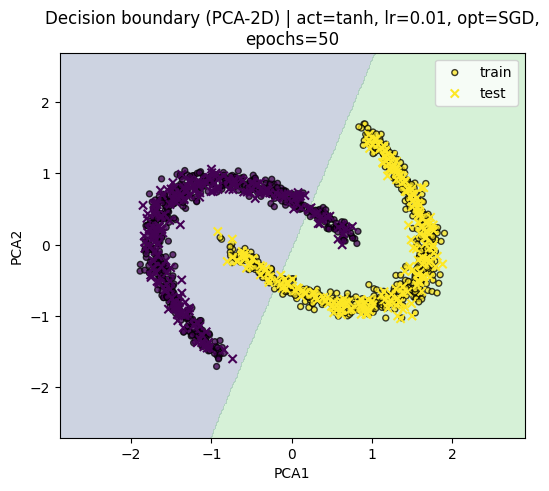

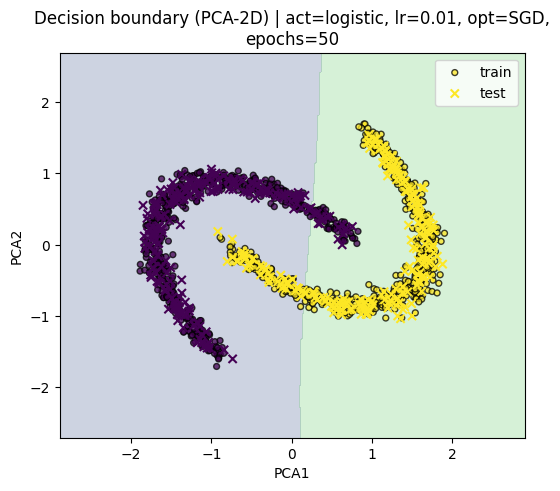

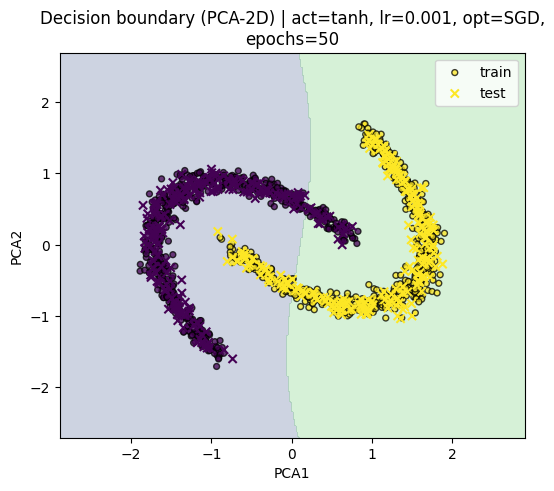

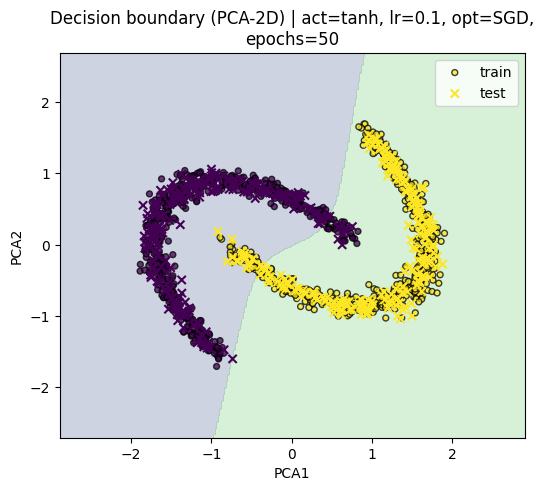

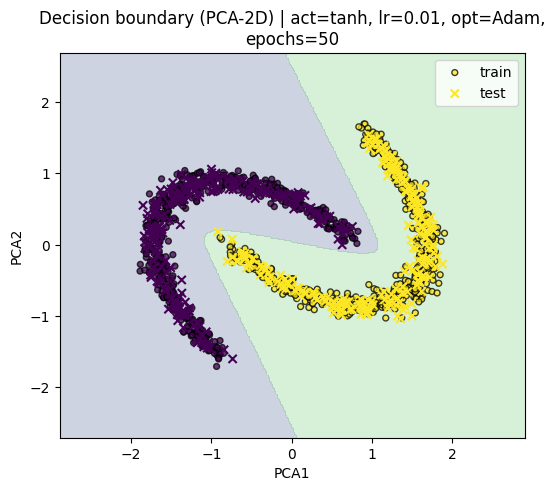

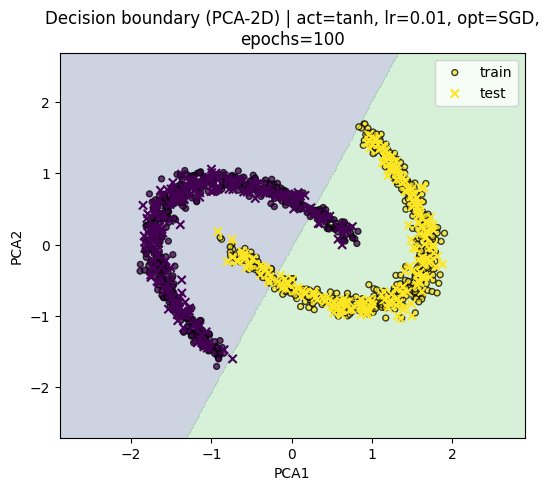

Saved PNGs for all experiments.


In [18]:
import matplotlib.pyplot as plt

for name, cfg in experiments.items():
    plt.ioff()  # turn off interactive display
    plot_decision_boundary_on_pca2(cfg, hidden=16)
    plt.savefig(f"decision_boundary_{name}.png", dpi=150, bbox_inches="tight")
    plt.close()
print("Saved PNGs for all experiments.")

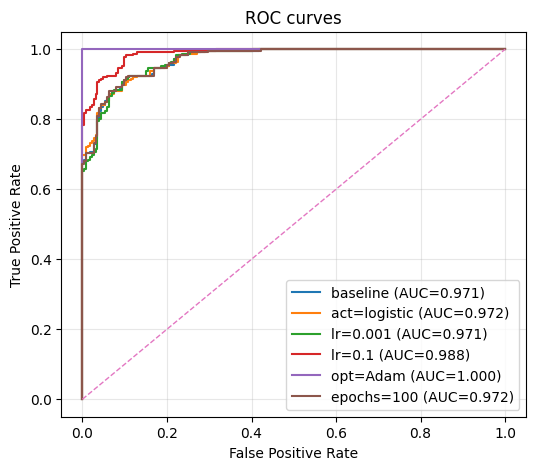

In [19]:
plot_rocs(results)

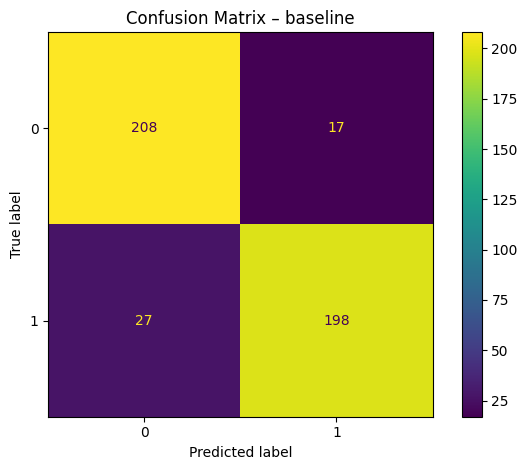

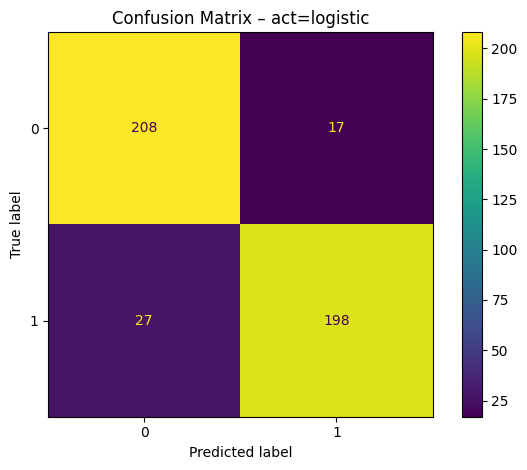

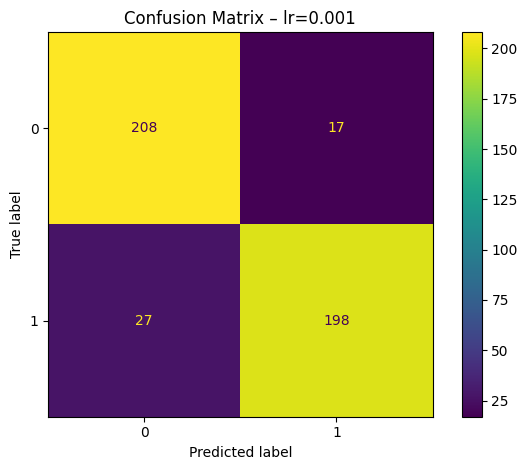

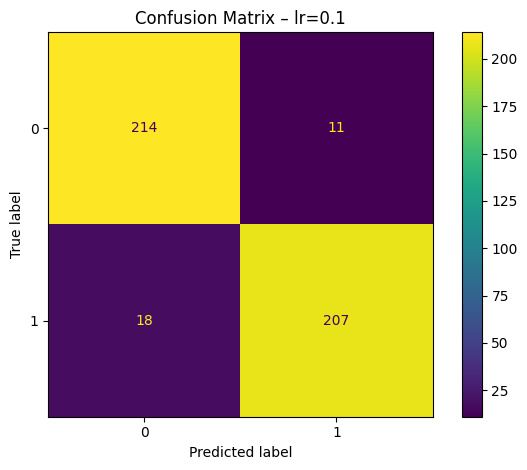

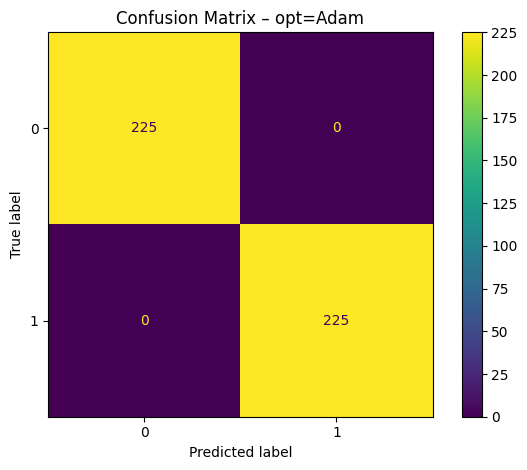

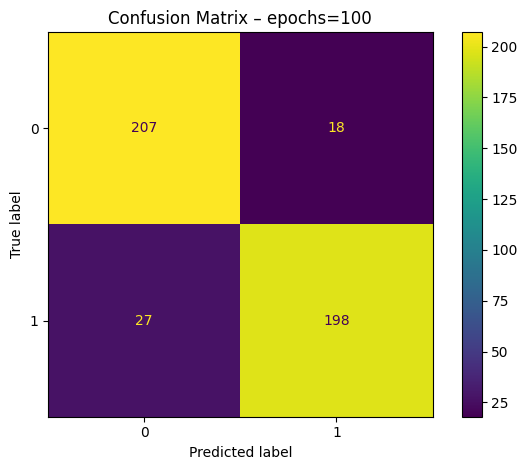

Saved PNGs:  ['cm_baseline.png', 'cm_act=logistic.png', 'cm_lr=0.001.png', 'cm_lr=0.1.png', 'cm_opt=Adam.png', 'cm_epochs=100.png']


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# show and save a confusion-matrix plot for every experiment
for name, m in results.items():
    cm = m["confusion_matrix"]
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix – {name}")
    plt.tight_layout()
    plt.savefig(f"cm_{name}.png", dpi=150, bbox_inches="tight")
    plt.show()

print("Saved PNGs: ", [f"cm_{name}.png" for name in results.keys()])


In [21]:
import pandas as pd
import numpy as np
import torch

# pick the best by AUC from your summary table
best_name = summary_df.loc[0, "Experiment"]
best_cfg  = experiments[best_name]
best_model = results[best_name]["model"]

# compute probabilities & predictions on the test set
with torch.no_grad():
    logits = best_model(X_test_t).cpu().numpy()
    probs  = 1.0 / (1.0 + np.exp(-logits))
    preds  = (probs >= 0.5).astype(int)

preds_df = pd.DataFrame({
    "y_true": y_test,           # numpy array (from earlier split)
    "y_prob": probs.ravel(),
    "y_pred": preds.ravel()
})

csv_name = f"predictions_{best_name}.csv"
preds_df.to_csv(csv_name, index=False)
print(f"Saved predictions to {csv_name}")
preds_df.head(10)

Saved predictions to predictions_opt=Adam.csv


,y_true,y_prob,y_pred
0,1,0.998920,1
1,0,0.003283,0
2,1,0.997629,1
3,0,0.001423,0
4,0,0.000084,0
5,1,0.997282,1
6,1,0.999808,1
7,1,0.999950,1
8,1,0.999948,1
9,0,0.000133,0


Saved: mlp_experiment_summary.csv


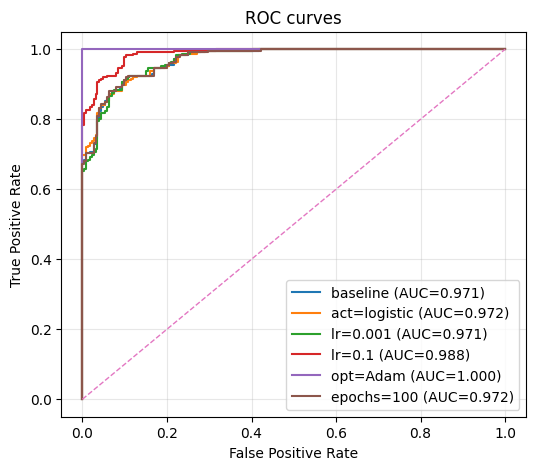

Saved: roc_all_experiments.png


In [22]:
# save summary table
summary_df.to_csv("mlp_experiment_summary.csv", index=False)
print("Saved: mlp_experiment_summary.csv")

# save combined ROC plot
plot_rocs(results)
plt.savefig("roc_all_experiments.png", dpi=150, bbox_inches="tight")
print("Saved: roc_all_experiments.png")

Project Report — MLP Neural Network Classification
1. Problem Statement
The objective of this exercise is to design and implement a Multilayer Perceptron (MLP) neural network to classify a binary-labeled dataset using PyTorch.
The dataset contains features for two classes, and the classification model should distinguish between them. The dataset is split into:
•	70% for training
•	30% for testing
The model will be trained with different parameter configurations to evaluate the effect of each parameter change on performance.
2. Goals
1.	Implement an MLP from scratch using PyTorch.
2.	Vary one parameter at a time while keeping others fixed, to study its impact.
3.	Compare results using:
o	Accuracy
o	Precision
o	Recall
o	F1 Score
o	AUC (Area Under the ROC Curve)
4.	Visualize:
o	Decision boundaries (PCA-2D)
o	ROC curves
3. Parameters to Vary
•	Activation Function:
o	tanh
o	logistic (sigmoid)
•	Learning Rate:
o	Low: 0.001
o	Baseline: 0.01
o	High: 0.1
•	Optimizer:
o	SGD
o	Adam
•	Training Epochs:
o	50
o	100
For each experiment, only one parameter is changed from the baseline configuration.
4. Dataset Preparation
•	Loaded CSV from Google Drive (/content/drive/MyDrive/Dataset.csv)
•	Separated features (X) and labels (y)
•	Label-encoded the target column
•	Standardized features using StandardScaler
•	Split into training and testing sets (train_test_split with stratify=y)
5. Model Architecture
•	Hidden Layer: Single fully connected layer (configurable hidden units)
•	Activation: tanh or sigmoid
•	Output Layer: Single neuron with sigmoid output for binary classification
•	Loss Function: BCEWithLogitsLoss
•	Optimizers: SGD or Adam
6. Experiments
The following configurations were tested:
Experiment	Activation	Learning Rate	Optimizer	Epochs
baseline	tanh	0.01	SGD	50
act=logistic	logistic	0.01	SGD	50
lr=0.001	tanh	0.001	SGD	50
lr=0.1	tanh	0.1	SGD	50
opt=Adam	tanh	0.01	Adam	50
epochs=100	tanh	0.01	SGD	100

7. Evaluation Metrics
For each configuration:
•	Confusion Matrix
•	Accuracy
•	Precision
•	Recall
•	F1 Score
•	AUC
8. Results Summary
Experiment	Accuracy	Precision	Recall	F1	AUC	TN	FP	FN	TP
opt=Adam	1.0000	1.0000	1.00	1.000	1.0000	225	0	0	225
lr=0.1	0.9356	0.9495	0.92	0.934	0.9877	214	11	18	207
act=logistic	0.9022	0.9209	0.88	0.907	0.9719	208	17	27	198
epochs=100	0.9000	0.9167	0.88	0.897	0.9718	207	18	27	198
baseline	0.9022	0.9209	0.88	0.907	0.9715	208	17	27	198
lr=0.001	0.9022	0.9209	0.88	0.907	0.9709	208	17	27	198

9. Visualizations
•	ROC Curves: All configurations plotted for comparison.
•	Decision Boundaries: PCA-2D projection of features with decision regions highlighted for each configuration.
10. Analysis
•	Best performance: opt=Adam achieved perfect classification (AUC = 1.0, Accuracy = 100%).
•	Increasing the learning rate to 0.1 improved AUC compared to baseline but slightly reduced recall.
•	Lowering the learning rate to 0.001 had minimal effect on metrics.
•	Logistic activation slightly reduced accuracy compared to tanh.
•	Doubling epochs from 50 to 100 did not significantly improve metrics, suggesting convergence was reached earlier.
11. Conclusion
•	Optimizer choice had the largest impact, with Adam outperforming SGD in this dataset.
•	Higher learning rate gave near-optimal results but requires careful tuning to avoid instability.
•	Activation choice affects performance slightly, with tanh performing marginally better here.
•	Increasing epochs without parameter changes may not yield improvements if the model has already converged.

